## Mise en place

In [74]:
import pandas as pd
import numpy as np
import gini

from util_data import DataSet

from sklearn.neighbors import KNeighborsRegressor

# added
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score


data = DataSet()

## Analyse avec panda

In [75]:
# I think we can use panda as an alternative for analysis, since it helps us gain more insights into the data

train = data.get_training_set()
test = data.get_testing_set()

In [76]:
# very pretty summary of each feature
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
# another util that helps look at the type of each feature
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [78]:
# take out 2 columns "id" and "target", group by target
# among all customers, 21694 claim an insurance, while 573518 do not
train[['target','id']].groupby(['target'], as_index=False).count()

,target,id
0,0,573518
1,1,21694


In [79]:
# separate data and label
X = train.drop(['id','target'],axis=1) # drop id and target from X, since "id" wouldn't do much help for prediction
Y = train['target'].as_matrix()

In [80]:
# we are told that features ending with 'cat' are categorical ones, we'd try to extract which features are indeed categorical
X.filter(like='cat').columns
# if needed, add .shape at the end to count the number of categorical features (17)

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [81]:
# do the same to extract binary features (14)
X.filter(like='bin').columns

Index(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='object')

In [82]:
# deal with missing values
# we are told that there are, indeed, missing values in the dataset, and those values are denoted by -1

train02 = train.replace(-1,np.nan) # replace all missing values (-1) by Nan
train02[train02.isnull().any(axis=1)].shape # get all rows that has Nan values

# there are 470 281 rows with missing values

(470281, 59)

In [83]:
logreg = LogisticRegression()
Y_pred = cross_val_predict(logreg, X.as_matrix(), Y, cv=5)

accuracy_score(Y_pred, Y)

0.96355248214081701

In [97]:
np.unique(Y_pred, return_counts=True)
# not cool :(

(array([0]), array([595212]))

Gini: 0.000, Max. Gini: 0.482, Normalized Gini: 0.001


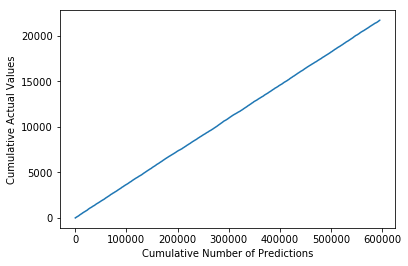

In [84]:
gini.gini_visualization(Y,Y_pred,True)

In [85]:
# compute feature importance
X_scaled = preprocessing.scale(X)

clf = ExtraTreesClassifier()
clf.fit(X_scaled,Y)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d of feature %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature 34 of feature ps_ind_01 (0.030471)
2. feature 46 of feature ps_ind_02_cat (0.029687)
3. feature 50 of feature ps_ind_03 (0.029605)
4. feature 47 of feature ps_ind_04_cat (0.029563)
5. feature 2 of feature ps_ind_05_cat (0.029335)
6. feature 38 of feature ps_ind_06_bin (0.028845)
7. feature 49 of feature ps_ind_07_bin (0.028803)
8. feature 39 of feature ps_ind_08_bin (0.028630)
9. feature 44 of feature ps_ind_09_bin (0.028572)
10. feature 37 of feature ps_ind_10_bin (0.028558)
11. feature 14 of feature ps_ind_11_bin (0.028530)
12. feature 43 of feature ps_ind_12_bin (0.028387)
13. feature 19 of feature ps_ind_13_bin (0.028365)
14. feature 42 of feature ps_ind_14 (0.028174)
15. feature 20 of feature ps_ind_15 (0.027857)
16. feature 45 of feature ps_ind_16_bin (0.027790)
17. feature 40 of feature ps_ind_17_bin (0.027363)
18. feature 41 of feature ps_ind_18_bin (0.027039)
19. feature 48 of feature ps_reg_01 (0.026832)
20. feature 31 of feature ps_reg_02 (0.02673

## Entrainement et Prédiction

In [86]:
clf = KNeighborsRegressor(n_neighbors=15,weights='distance')
clf.fit(Xtr,Ytr)

Ypred = clf.predict(Xtst)

## Analyse

Gini: 0.043, Max. Gini: 0.482, Normalized Gini: 0.089


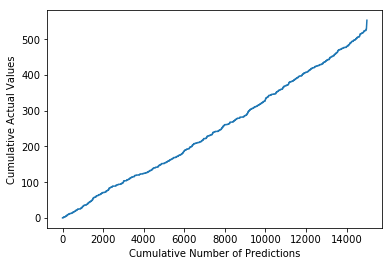

In [87]:
gini.gini_visualization(Ytst,Ypred,True)